# **CAR PRICE PREDICTION NOTEBOOK**

## **Summary**
1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Training: learning curves
7. Model finalization
8. Test on unseen data

.

.

## **1. Importing libraries and data**

In [434]:
#Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
import difflib
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [435]:
#Importing data
Data = pd.read_csv("CarPrice_Assignment.csv")
Data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [436]:
#Features info
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [437]:
#No missing values in the dataset. There are 10 "object" categorical features that must be treated before training:
# - CarName, fueltype, aspiration, doornumber
# - carbody, drivewheel, enginelocation
# - enginetype, cylindernumber, fuelsystem


#Creation of a Training set and a Test set.
#The Training set will be used in the training session
#The Test set will be 0.05% (~10 samples) of the original dataset and it will be used at the end of the notebook as "unseen data".
X_train, X_test, y_train, y_test = train_test_split(Data.drop(["price"],axis=1), Data.price, test_size = 0.05, random_state = 42, shuffle=True)
X_train

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
164,165,1,toyota corona,gas,std,two,hatchback,rwd,front,94.5,...,four,98,2bbl,3.19,3.03,9.0,70,4800,29,34
65,66,0,mazda glc,gas,std,four,sedan,rwd,front,104.9,...,four,140,mpfi,3.76,3.16,8.0,120,5000,19,27
175,176,-1,toyota corona,gas,std,four,hatchback,fwd,front,102.4,...,four,122,mpfi,3.31,3.54,8.7,92,4200,27,32
73,74,0,buick century special,gas,std,four,sedan,rwd,front,120.9,...,eight,308,mpfi,3.80,3.35,8.0,184,4500,14,16
152,153,1,toyota corolla 1200,gas,std,four,hatchback,fwd,front,95.7,...,four,92,2bbl,3.05,3.03,9.0,62,4800,31,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,1,nissan clipper,gas,std,two,hatchback,rwd,front,99.2,...,six,181,mpfi,3.43,3.27,9.0,160,5200,19,25
14,15,1,bmw z4,gas,std,four,sedan,rwd,front,103.5,...,six,164,mpfi,3.31,3.19,9.0,121,4250,20,25
92,93,1,nissan latio,gas,std,four,sedan,fwd,front,94.5,...,four,97,2bbl,3.15,3.29,9.4,69,5200,31,37
179,180,3,toyota corona,gas,std,two,hatchback,rwd,front,102.9,...,six,171,mpfi,3.27,3.35,9.3,161,5200,19,24


.

.

## **2. Data cleaning and preparation**

In [438]:
#Drop "car_ID" column (not useful for predicting the car price)
X_train.drop(["car_ID"],axis=1, inplace=True)

#Print unique values of "object" features
for i in X_train.columns :
    if X_train[i].dtype == "object" :
        print(i, ": ", X_train[i].unique())

CarName :  ['toyota corona' 'mazda glc' 'buick century special' 'toyota corolla 1200'
 'chevrolet impala' 'mitsubishi outlander' 'mitsubishi pajero'
 'subaru baja' 'mazda glc custom l' 'nissan dayz' 'nissan clipper'
 'honda civic' 'dodge colt hardtop' 'bmw x5' 'toyota corolla'
 'volvo 144ea' 'nissan note' 'volvo 145e (sw)' 'buick electra 225 custom'
 'plymouth fury iii' 'toyota corolla 1600 (sw)' 'volvo 244dl'
 'mitsubishi g4' 'buick century' 'subaru r2' 'mazda 626'
 'isuzu D-Max V-Cross' 'mitsubishi mirage g4' 'subaru trezia'
 'mazda rx-7 gs' 'peugeot 504' 'toyota corona hardtop' 'nissan latio'
 'honda civic 1300' 'dodge monaco (sw)' 'subaru dl' 'peugeot 604sl'
 'dodge coronet custom (sw)' 'chevrolet monte carlo'
 'toyota corolla liftback' 'nissan gt-r' 'nissan titan' 'audi fox'
 'toyota corona liftback' 'porsche boxter' 'mitsubishi mirage' 'subaru r1'
 'nissan teana' 'toyota mark ii' 'mercury cougar' 'toyota celica gt'
 'honda civic cvcc' 'bmw x1' 'honda accord lx' 'porsche macan'
 '

In [439]:
#Reduce "CarName" to lower cases
for i in X_train.columns :
    if X_train[i].dtype == "object" :
        X_train[i] = X_train[i].map(lambda p: p.lower())
        
#The feature "CarName" has a lot of unique values and it will be treated later.

#Convert strings to numbers.
#Only "cylindernumber" and "doornumber" have a rank order that must be kept into account (additional information can be added - e.g. a different number of doors/cylinders)
X_train["doornumber"].replace(['two','three','four'], [2,3,4], inplace=True)
X_train["cylindernumber"].replace(['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve'], [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)

for i in X_train.columns :
    if (X_train[i].dtype == "object") & (i != "doornumber") & (i != "cylindernumber") & (i != "CarName") :
        exec(f"X_range_{i} = np.sort(X_train[i].unique()); X_train[i].replace(X_range_{i},np.arange(1,len(X_range_{i})+1), inplace=True)")

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 164 to 102
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         194 non-null    int64  
 1   CarName           194 non-null    object 
 2   fueltype          194 non-null    int64  
 3   aspiration        194 non-null    int64  
 4   doornumber        194 non-null    int64  
 5   carbody           194 non-null    int64  
 6   drivewheel        194 non-null    int64  
 7   enginelocation    194 non-null    int64  
 8   wheelbase         194 non-null    float64
 9   carlength         194 non-null    float64
 10  carwidth          194 non-null    float64
 11  carheight         194 non-null    float64
 12  curbweight        194 non-null    int64  
 13  enginetype        194 non-null    int64  
 14  cylindernumber    194 non-null    int64  
 15  enginesize        194 non-null    int64  
 16  fuelsystem        194 non-null    int64  


In [440]:
#For what concerns the feature "CarName", the first part is the car brand followed by a subclass. For training, let's keep only the car brand
X_train["CarName"] = X_train["CarName"].str.split(" ", expand=True)[0]
np.sort(X_train["CarName"].unique())

array(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge',
       'honda', 'isuzu', 'jaguar', 'maxda', 'mazda', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porcshce',
       'porsche', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'volkswagen', 'volvo', 'vw'], dtype=object)

In [441]:
#There are two mispelled words:
#  - toyouta     for    toyota
#  - porcshce    for    porsche

#Correction
Index1 = np.where(X_train["CarName"]=="toyouta")[0]
Index2 = np.where(X_train["CarName"]=="porcshce")[0]
X_train["CarName"].iloc[Index1] = "toyota"
X_train["CarName"].iloc[Index2] = "porsche"

X_train["CarName"] = X_train["CarName"].str.split(" ", expand=True)[0]
np.sort(X_train["CarName"].unique())

array(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge',
       'honda', 'isuzu', 'jaguar', 'maxda', 'mazda', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],
      dtype=object)

In [442]:
#Convert strings to numbers
X_train["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda', 'isuzu', 
                            'jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan', 'peugeot', 'plymouth', 
                            'porsche','renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],
                            [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 164 to 102
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         194 non-null    int64  
 1   CarName           194 non-null    int64  
 2   fueltype          194 non-null    int64  
 3   aspiration        194 non-null    int64  
 4   doornumber        194 non-null    int64  
 5   carbody           194 non-null    int64  
 6   drivewheel        194 non-null    int64  
 7   enginelocation    194 non-null    int64  
 8   wheelbase         194 non-null    float64
 9   carlength         194 non-null    float64
 10  carwidth          194 non-null    float64
 11  carheight         194 non-null    float64
 12  curbweight        194 non-null    int64  
 13  enginetype        194 non-null    int64  
 14  cylindernumber    194 non-null    int64  
 15  enginesize        194 non-null    int64  
 16  fuelsystem        194 non-null    int64  


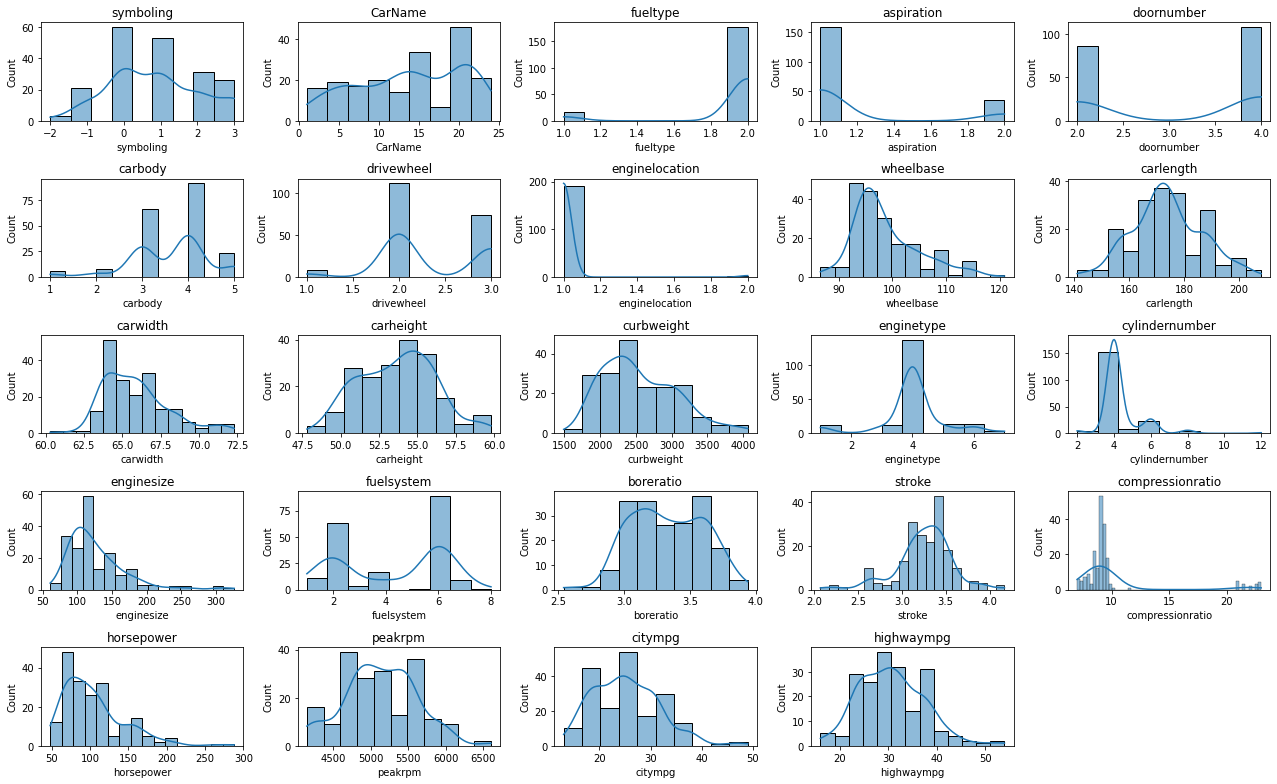

In [443]:
#Data distribution
plt.figure(figsize=(18,11))
k=1
for i in X_train.columns :
    plt.subplot(5,5,k)
    sn.histplot(x=X_train[i],kde=True)
    plt.title(i)
    k=k+1
plt.tight_layout()

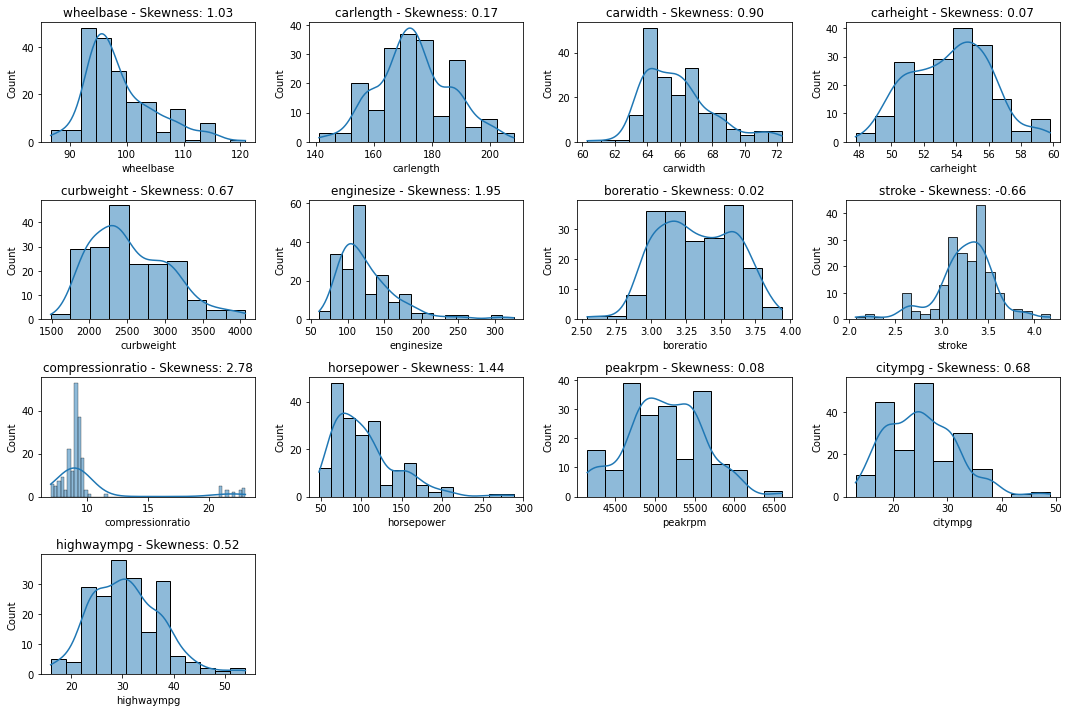

In [444]:
#Front the plots above:
# - The majority of car engines work with gas ("fueltype")
# - The majority of cars have the engine on the front ("enginelocation")
# - The majority of cars have an engine type "l" ("enginetype")

#Data distribution: numerical features
plt.figure(figsize=(15,10))
k=1
for i in ["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"] :
    plt.subplot(4,4,k)
    sn.histplot(x=X_train[i],kde=True)
    plt.title("{} - Skewness: {:.2f}".format(i, skew(X_train[i])))
    k=k+1
plt.tight_layout()

Text(0.5, 0, 'Range')

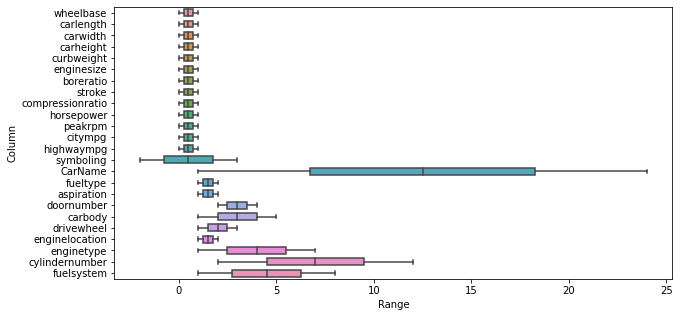

In [445]:
#Scale numerical features with MinMaxScaler function
Numeric_scaler = MinMaxScaler()               #It will be used later
Numeric_scaler.fit(X_train[["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"]])

A = Numeric_scaler.transform(X_train[["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"]])

B = np.concatenate([A,np.array(X_train.drop(["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"],axis=1))],axis=1)

Final_columns = ["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
     "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg","symboling",
     "CarName","fueltype","aspiration","doornumber","carbody","drivewheel","enginelocation",
     "enginetype","cylindernumber","fuelsystem"]

X_train = pd.DataFrame(B, columns=Final_columns)


#Plot: range for each feature
Minmax = pd.DataFrame(np.zeros((2*X_train.shape[1],2)), columns = ["Column","Value"])
k=0
for i in X_train.columns :
    Minmax.Column[k] = i
    Minmax.Value[k] = X_train[i].min()
    k=k+1
    Minmax.Column[k] = i
    Minmax.Value[k] = X_train[i].max()
    k=k+1

plt.figure(figsize=(10,5))
sn.boxplot(x = "Value", y="Column", data=Minmax, whis=[0, 100], width=.6)
plt.xlabel("Range")

In [446]:
#The majority of features values lie in ranges between ~0 and ~10 (except for "CarName" with a range between 1 and 24)


#Correlation Matrix (to find possible correlated features with a correlation coefficient larger than 0.8)
High_corr = pd.DataFrame([X_train.columns[np.where((abs(X_train.corr())>=0.8))[0]],
                          X_train.columns[np.where((abs(X_train.corr())>=0.8))[1]]],
                         index=["Val1","Val2"]).T
    
High_corr.drop(np.where(High_corr.Val1 == High_corr.Val2)[0],axis=0, inplace=True)        #Remove diagonal correlations
High_corr

,Val1,Val2
1,wheelbase,carlength
2,carlength,wheelbase
4,carlength,carwidth
5,carlength,curbweight
6,carwidth,carlength
8,carwidth,curbweight
10,curbweight,carlength
11,curbweight,carwidth
13,curbweight,enginesize
14,curbweight,highwaympg


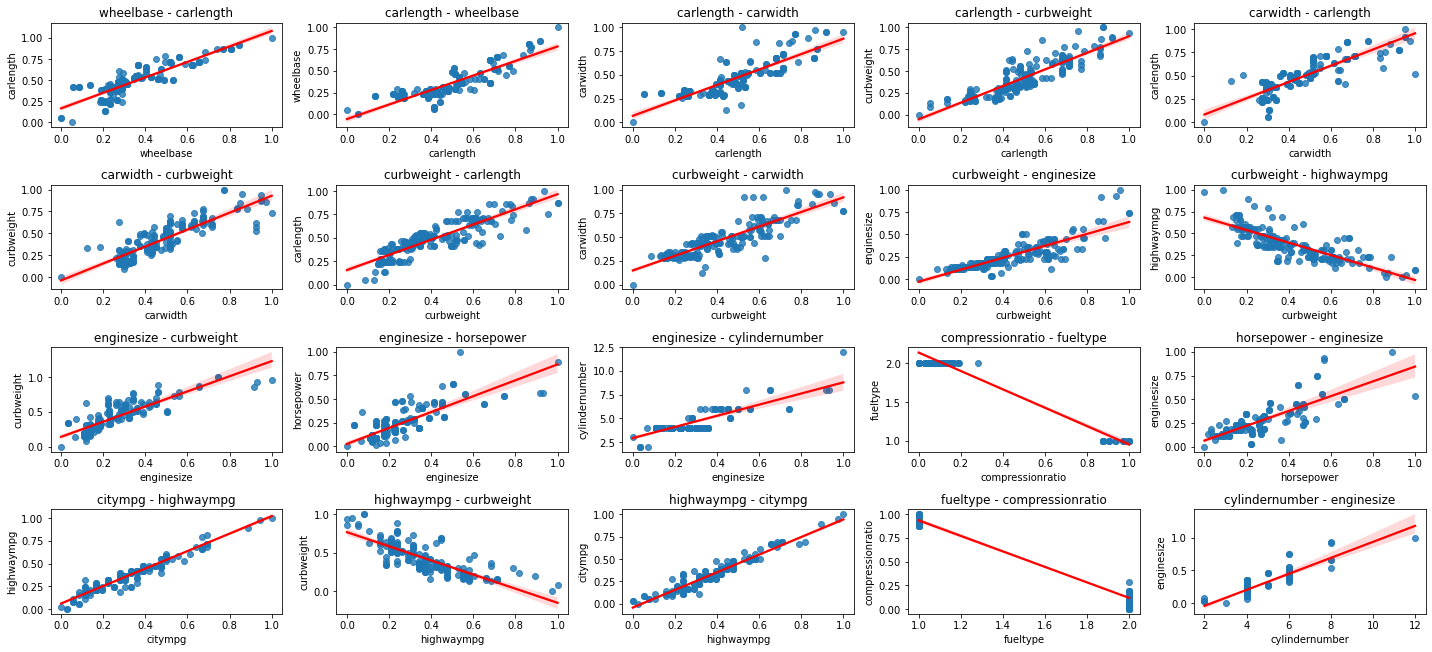

In [447]:
#Plot of the correlated features
plt.figure(figsize=(20,20))
k=1
i=0
while i<len(High_corr) :
    plt.subplot(9,5,k)
    sn.regplot(data = X_train, x = High_corr.Val1.iloc[i], y = High_corr.Val2.iloc[i], line_kws={"color": "red"})
    plt.title("{} - {}".format(High_corr.Val1.iloc[i],High_corr.Val2.iloc[i]))
    i=i+1
    k=k+1
plt.tight_layout()

Text(0.5, 1.0, 'Skewness: 1.79')

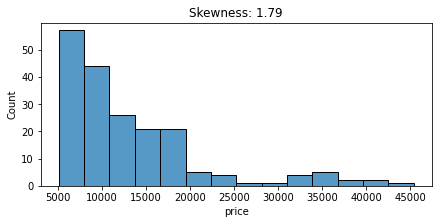

In [448]:
#From the plots above:
# - Some features are highly correlated (e.g. citympg vs. highwaympg)
# - Some of them are correlated with what it seems a second degree polynomial (e.g., curbweight vs. enginesize)
#However, there is still a visible scatter in all plots therefore, in this notebook, all features will be used to predict the car price.


#Target variable
plt.figure(figsize=(7,3))
sn.histplot(x=y_train)
plt.title("Skewness: {:.2f}".format(skew(y_train)))

Text(0.5, 1.0, 'Skewness: 0.66')

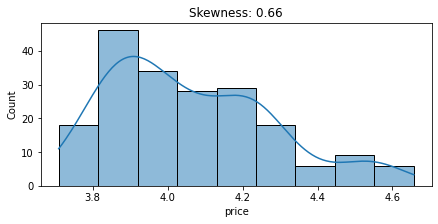

In [449]:
#Log-transformation
y_train = np.log10(y_train)

#Plot
plt.figure(figsize=(7,3))
sn.histplot(x=y_train,kde=True)
plt.title("Skewness: {:.2f}".format(skew(y_train)))

In [450]:
#Skewness reduced

#Correlation coefficients between features and target variable
pd.concat([X_train,pd.Series(np.array(y_train),name="price")],axis=1).corr()["price"]

wheelbase           0.620727
carlength           0.764867
carwidth            0.800850
carheight           0.146186
curbweight          0.888148
enginesize          0.827255
boreratio           0.613364
stroke              0.085135
compressionratio    0.101169
horsepower          0.823451
peakrpm            -0.096283
citympg            -0.772052
highwaympg         -0.777258
symboling          -0.071397
CarName            -0.163626
fueltype           -0.145364
aspiration          0.239662
doornumber          0.077567
carbody            -0.049461
drivewheel          0.622114
enginelocation      0.272964
enginetype          0.007576
cylindernumber      0.625081
fuelsystem          0.654873
price               1.000000
Name: price, dtype: float64

In [451]:
#From the results above:
# - Some features are highly correlated and they might be very important in predicting the final car price.
# - Some others are less correlated (e.g. enginetype, carbody).
#In this notebook, all features will be used in the training session.

.

.

## **3. Data transformation function**

In [452]:
#Function to transform new data (before the application of the final model) adopting all the procedures and transformations shown above.
#The function includes also an additional procedure to find and correct mispelled words

def Data_transformation(X,y) :                        #Input variables and target variable as inputs
    #(1A) Drop "car_ID" column
    X.drop(["car_ID"],axis=1, inplace=True)

    #(1B) Reduce "object" features to lower cases
    for i in X.columns :
        if X[i].dtype == "object" :
            X[i] = X[i].map(lambda p: p.lower())
            
    #(2) Categorical features
    X["doornumber"].replace(['two','three','four'], [2,3,4], inplace=True)
    X["cylindernumber"].replace(['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve'], [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
    
    for i in X.columns :
        if (X[i].dtype == "object") & (i != "doornumber") & (i != "cylindernumber") & (i != "CarName") :
            exec(f"X[i].replace(X_range_{i},np.arange(1,len(X_range_{i})+1), inplace=True)")

    #(3) CarName
    X["CarName"] = X["CarName"].str.split(" ", expand=True)[0]
    X["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda', 'isuzu', 
                        'jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan', 'peugeot', 'plymouth', 
                        'porsche','renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], inplace=True)
    
    #(4) Min Max scaler of numerical features
    A = Numeric_scaler.transform(X[["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"]])
    B = np.concatenate([A,np.array(X.drop(["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"],axis=1))],axis=1)
    Final_columns = ["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
     "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg","symboling",
     "CarName","fueltype","aspiration","doornumber","carbody","drivewheel","enginelocation",
     "enginetype","cylindernumber","fuelsystem"]
    X = pd.DataFrame(B, columns=Final_columns)

    
    #(5) Correct Mispelled words for each categorical feature
    Row = []
    Col = []
    for i in range(X.shape[0]) :
        for j in range(X.shape[1]) :
            if isinstance(X.iloc[i,j], str) == True :
                Row.append(i)
                Col.append(j)
            
    if len(Row)>0 :
        for i in range(len(Row)) :
            a = X.columns[Col[i]]
            if a == "CarName" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], ['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda', 'isuzu', 
                            'jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan', 'peugeot', 'plymouth', 
                            'porsche','renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda', 'isuzu', 
                            'jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan', 'peugeot', 'plymouth', 
                            'porsche','renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], inplace=True)
                
            elif a == "doornumber" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], ['two','three','four'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["doornumber"].replace(['two','three','four'],[2,3,4], inplace=True)
            
            elif a == "cylindernumber" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]],['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["cylindernumber"].replace(['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve'],[1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
            
            else :
                exec("Values = X_range_{a}")
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], Values)
                X.iloc[Row[i],Col[i]] = b[0]
    
    #(6) Object-to-numeric convertion (if the conversion produces NaN values, they will be replaced with 0)
    for i in X.columns :
        X[i] = pd.to_numeric(X[i], errors='coerce').fillna(int(0))
    
    #(7) Target variable (some indexing of the training set)
    y = np.log10(y)
    y = pd.Series(np.array(y),name="price")   
    
    return X,y

.

.

## **4. Training: first models**

In [453]:
#Creation of a Training set (to train models) and a Validation set (to understand the goodness of the models).
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, shuffle=True)

In [454]:
#A repeated random sampling cross-validation method will be used to evaluate each model mean score in terms of RMSE, MAE, and R2.

Iterations = 50
RMSE_lin, RMSE_rid, RMSE_tree, RMSE_ran, RMSE_xgb = 0,0,0,0,0
MAE_lin, MAE_rid, MAE_tree, MAE_ran, MAE_xgb = 0,0,0,0,0
R2_lin, R2_rid, R2_tree, R2_ran, R2_xgb = 0,0,0,0,0
for i in range(Iterations) :
    #Training and Validation set (80-20%)
    X_tr, X_va, y_tr, y_va = train_test_split(X_train_t, y_train_t, test_size = 0.2, random_state = np.random.randint(1,100))
    
    #Linear
    Model_lin = LinearRegression()
    Model_lin2 = Model_lin.fit(X_tr, y_tr)
    RMSE_lin = RMSE_lin + np.sqrt(sum((Model_lin2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_lin = MAE_lin + sum(abs(Model_lin2.predict(X_va) - y_va))/len(y_va)
    R2_lin = R2_lin + r2_score(y_va,Model_lin2.predict(X_va))
    
    #Ridge
    Model_rid = Ridge()
    Model_rid2 = Model_rid.fit(X_tr, y_tr)
    RMSE_rid = RMSE_rid + np.sqrt(sum((Model_rid2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_rid = MAE_rid + sum(abs(Model_rid2.predict(X_va) - y_va))/len(y_va)
    R2_rid = R2_rid + r2_score(y_va,Model_rid2.predict(X_va))
    
    #Decision Tree
    Model_tree = DecisionTreeRegressor()           
    Model_tree2 = Model_tree.fit(X_tr, y_tr)
    RMSE_tree = RMSE_tree + np.sqrt(sum((Model_tree2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_tree = MAE_tree + sum(abs(Model_tree2.predict(X_va) - y_va))/len(y_va)
    R2_tree = R2_tree + r2_score(y_va,Model_tree2.predict(X_va))

    #Random Forest
    Model_ran = RandomForestRegressor()           
    Model_ran2 = Model_ran.fit(X_tr, y_tr)
    RMSE_ran = RMSE_ran + np.sqrt(sum((Model_ran2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_ran = MAE_ran + sum(abs(Model_ran2.predict(X_va) - y_va))/len(y_va)
    R2_ran = R2_ran + r2_score(y_va,Model_ran2.predict(X_va))
    
    #XGBoost
    Model_xgb = xgb.XGBRegressor()
    Model_xgb2 = Model_xgb.fit(X_tr, y_tr)
    RMSE_xgb = RMSE_xgb + np.sqrt(sum((Model_xgb2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_xgb = MAE_xgb + sum(abs(Model_xgb2.predict(X_va) - y_va))/len(y_va)
    R2_xgb = R2_xgb + r2_score(y_va,Model_xgb2.predict(X_va))
    

#First results
Data_res = {"RMSE": [RMSE_lin/Iterations, RMSE_rid/Iterations, RMSE_tree/Iterations, RMSE_ran/Iterations, RMSE_xgb/Iterations],
            "MAE": [MAE_lin/Iterations, MAE_rid/Iterations, MAE_tree/Iterations, MAE_ran/Iterations, MAE_xgb/Iterations],
            "R2": [R2_lin/Iterations, R2_rid/Iterations, R2_tree/Iterations, R2_ran/Iterations, R2_xgb/Iterations]}
        
Results = pd.DataFrame(data = Data_res, index=["Linear","Ridge","DecisionTree","RandomForest","XGBoost"])
Results

,RMSE,MAE,R2
Linear,0.070269,0.055238,0.880737
Ridge,0.069974,0.056332,0.881583
DecisionTree,0.080024,0.062019,0.844318
RandomForest,0.062209,0.048370,0.905237
XGBoost,0.067132,0.054058,0.890751


.

.

## **5. Training: hyperparameters tuning**

In [455]:
#Let's consider Random Forest, XGBoost, and Ridge (for regularization) and tune their hyperparameters (the MAE will be the scoring metric)

#Hyperameters grid
Params_rid = {"alpha":[0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]}
Params_xgb = {"n_estimators":[100,200,300], "eta":[0.1,0.3,0.5], "max_depth":[2,3,4,5,6]}
Params_ran = {"n_estimators":[100,200,300], "max_depth":[2,3,4,5]}

#Grid search with a 5-fold cross-validation method (the score will be the MAE)
CV = KFold(n_splits=5, random_state = 42, shuffle=True)
Grid_rid = GridSearchCV(Model_rid, cv = CV, param_grid = Params_rid, scoring = "neg_mean_absolute_error", n_jobs = -1)
Grid_rid2 = Grid_rid.fit(X_train_t, y_train_t)
print("Ridge model: done!")
Grid_xgb = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "neg_mean_absolute_error", n_jobs = -1)
Grid_xgb2 = Grid_xgb.fit(X_train_t, y_train_t)
print("XGBoost model: done!")
Grid_ran = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "neg_mean_absolute_error", n_jobs = -1)
Grid_ran2 = Grid_ran.fit(X_train_t, y_train_t)
print("RandomForest model: done!")

print("\n\nThe best Ridge Regression model is: ", Grid_rid2.best_params_)
print("The best XGBoost Regression model is: ",Grid_xgb2.best_params_)
print("The best Random Forest Regression model is: ",Grid_ran2.best_params_)
print("\nThe best Ridge Regression MAE is: ", -Grid_rid2.best_score_)
print("The best XGBoost Regression MAE is: ",-Grid_xgb2.best_score_)
print("The best Random Forest Regression MAE is: ",-Grid_ran2.best_score_)

Ridge model: done!
XGBoost model: done!
RandomForest model: done!


The best Ridge Regression model is:  {'alpha': 0.1}
The best XGBoost Regression model is:  {'eta': 0.1, 'max_depth': 2, 'n_estimators': 100}
The best Random Forest Regression model is:  {'max_depth': 5, 'n_estimators': 300}

The best Ridge Regression MAE is:  0.055711987705530396
The best XGBoost Regression MAE is:  0.05112925209526883
The best Random Forest Regression MAE is:  0.04925633722848384


.

.

## **6. Training: learning curves**

Ridge model: done!
XGBoost model: done!
RandomForest model: done!


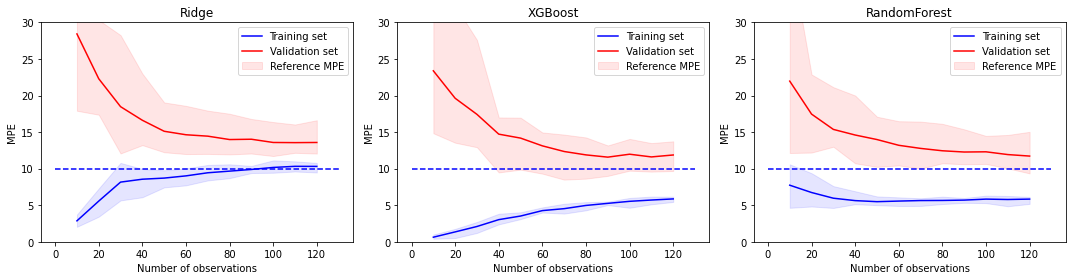

In [456]:
#Learning curves of the three models (Ridge, XGBoost, Random Forest).
#Each curve (i.e., training and validation) is the average curve computed in 10 different random samplings.
#As a reference value, a MPE of 10% will be drawn in each plot (dashed blue line).

Models = ["Ridge","XGBoost","RandomForest"]
plt.figure(figsize=(15,4))
kk=0
for model in [Ridge(**Grid_rid2.best_params_), xgb.XGBRegressor(**Grid_xgb2.best_params_), RandomForestRegressor(**Grid_ran2.best_params_)] :
    #Ridge
    #Best_parameters = Grid_rid2.best_params_
    #Model_rid_final = Ridge(**Grid_rid2.best_params_)
    ACC_tot_tr = np.zeros((12,10))
    ACC_tot_va = np.zeros((12,10))
    for k in range(10) :
        X_tr, X_va, y_tr, y_va = train_test_split(X_train_t, y_train_t, test_size = 0.2, random_state = np.random.randint(1,100))
        Accu_tr = []
        Accu_va = []
        i=0
        while i<int(len(X_tr)/10) :
            Tr1 = X_tr.iloc[0:10+10*i,]
            y1 = y_tr.iloc[0:10+10*i,]
            Tr2 = X_va.iloc[0:10+10*i,]
            y2 = y_va.iloc[0:10+10*i,]
            M = model
            Model = M.fit(Tr1, y1)
            Accu_tr.append(100*abs((10**Model.predict(Tr1) - 10**y1)/(10**y1)).sum()/len(y1))
            Accu_va.append(100*abs((10**Model.predict(Tr2) - 10**y2)/(10**y2)).sum()/len(y2))
            i=i+1
        ACC_tot_tr[:,k] = Accu_tr
        ACC_tot_va[:,k] = Accu_va

    Mean_acc_tr = ACC_tot_tr[:,0]
    Mean_acc_va = ACC_tot_va[:,0]
    for k in range(9) :
        Mean_acc_tr = Mean_acc_tr + ACC_tot_tr[:,k+1]
        Mean_acc_va = Mean_acc_va + ACC_tot_va[:,k+1]

    Mean_acc_tr_max = []
    Mean_acc_va_max = []
    Mean_acc_tr_min = []
    Mean_acc_va_min = []
    for k in range(len(ACC_tot_tr)) :
        Mean_acc_tr_max.append(ACC_tot_tr[k,:].max())
        Mean_acc_va_max.append(ACC_tot_va[k,:].max())
        Mean_acc_tr_min.append(ACC_tot_tr[k,:].min())
        Mean_acc_va_min.append(ACC_tot_va[k,:].min())

    plt.subplot(1,3,kk+1)
    plt.plot(10+10*np.arange(0,int(len(X_tr)/10)),Mean_acc_tr/10,'blue')
    plt.plot(10+10*np.arange(0,int(len(X_tr)/10)),Mean_acc_va/10,'red')
    plt.fill_between(10+10*np.arange(0,int(len(X_tr)/10)), Mean_acc_va_max, Mean_acc_va_min, color="red",alpha=0.1)
    plt.fill_between(10+10*np.arange(0,int(len(X_tr)/10)), Mean_acc_tr_max, Mean_acc_tr_min, color="blue",alpha=0.1)
    plt.plot([0,130],[10.0,10.0], '--b')
    plt.xlabel("Number of observations")
    plt.ylabel("MPE")
    plt.ylim([0.0,30.0])
    plt.title(Models[kk])
    plt.legend(["Training set","Validation set","Reference MPE"])
    print("{} model: done!".format(Models[kk]))
    kk=kk+1
plt.tight_layout()

97.222222222222236

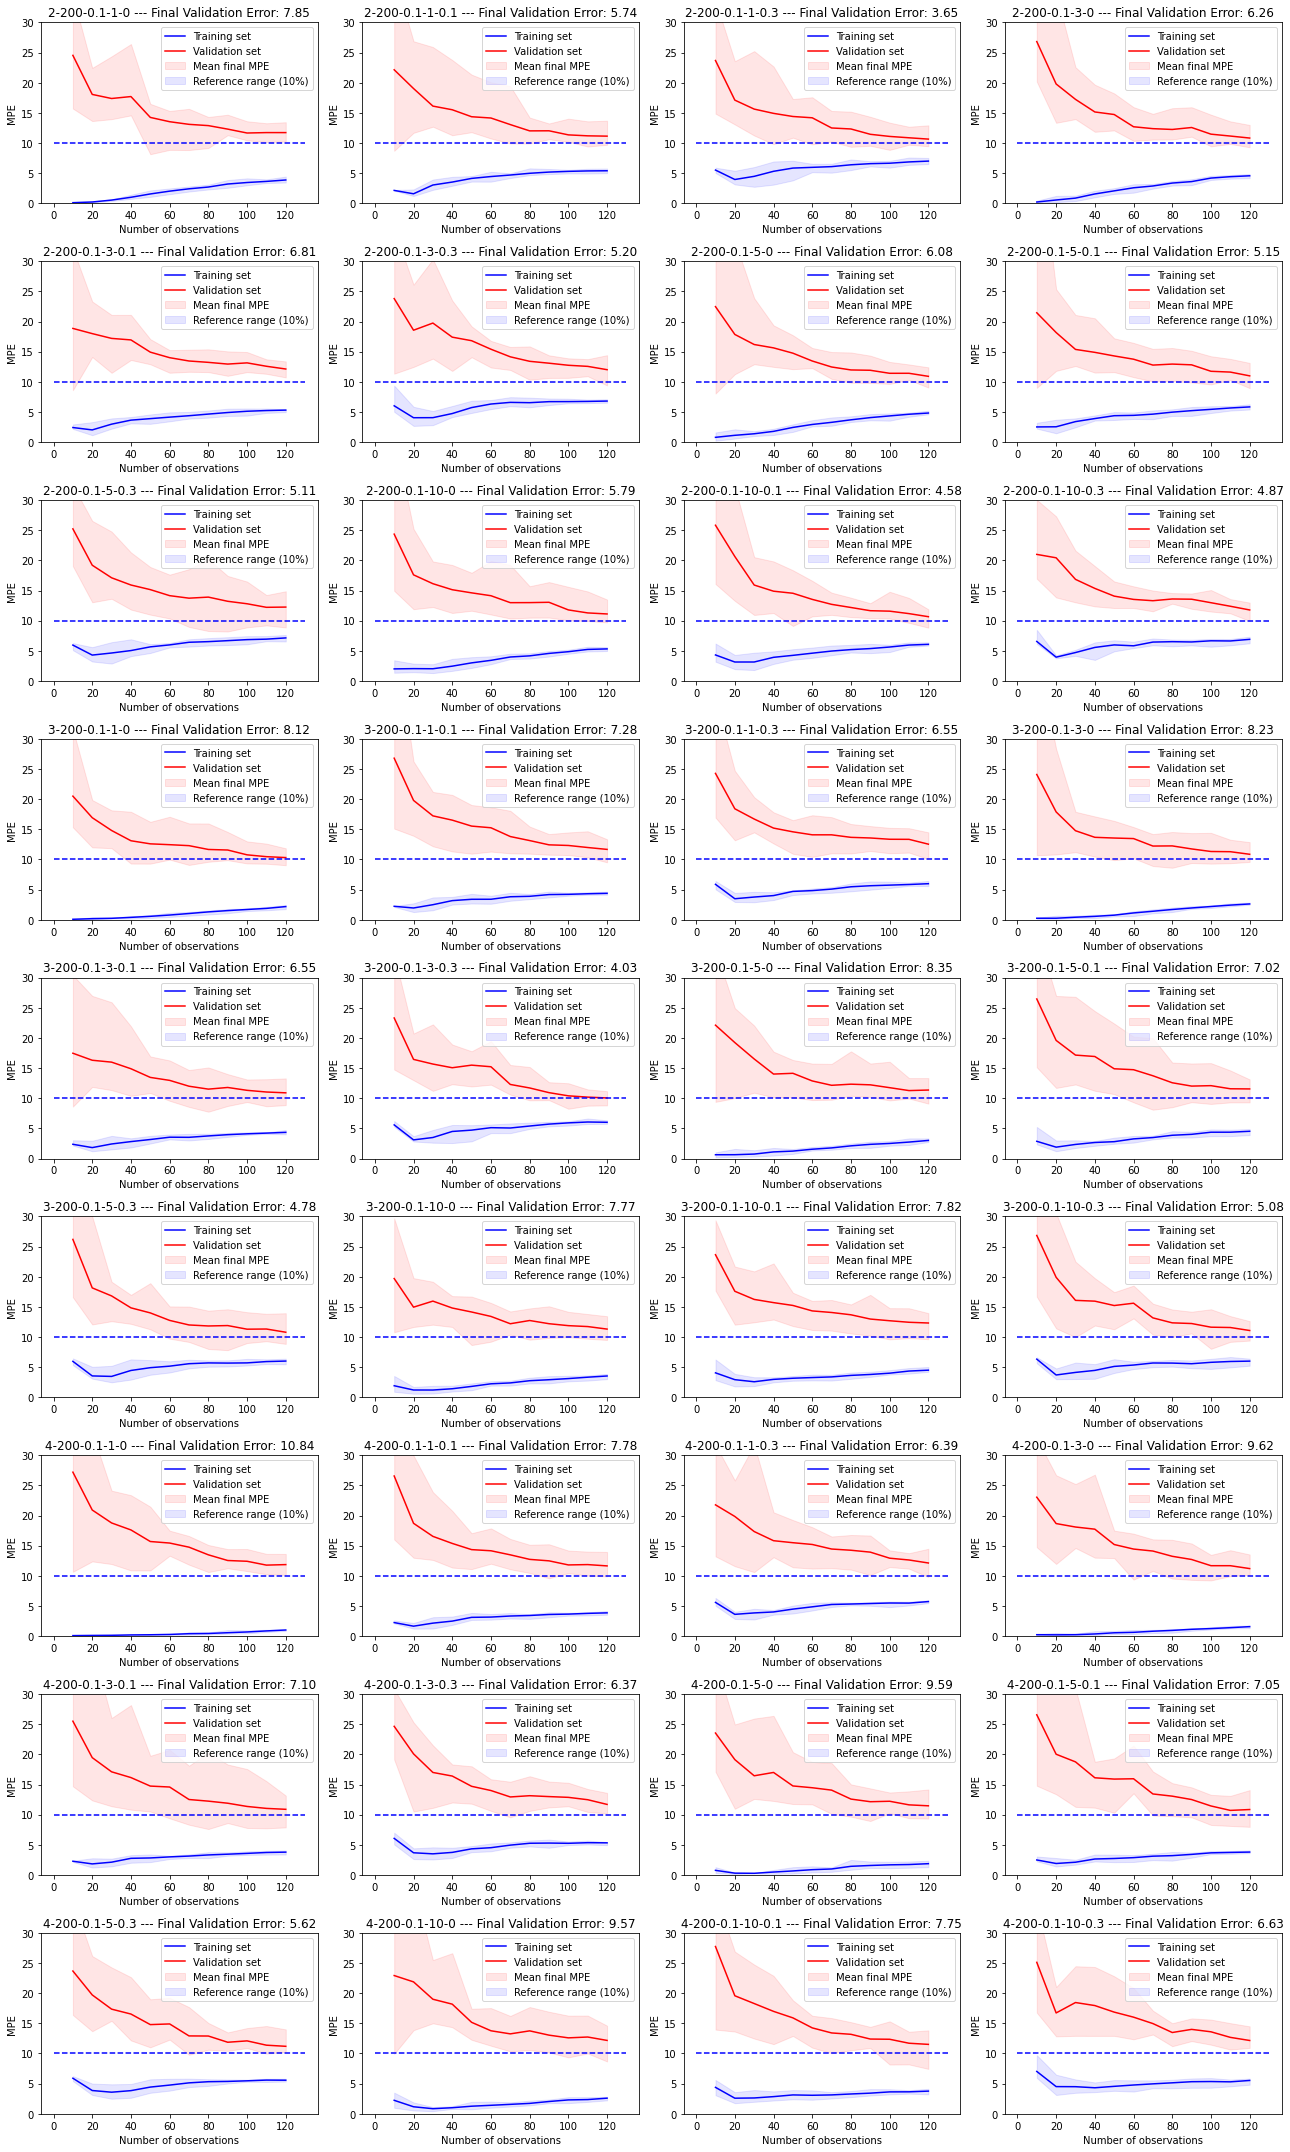

In [457]:
#Both XGBoost and Random Forest learning curves represent a slightly overfitting case (i.e. training and validation curves are distant).
#For what concerns the Ridge model, the two curves are closer to each other even though above the reference MPE value (10%).
#From now on, let's consider the XGBoost model.

#Exploration of the hyperparameter space along with learning curves for each model.
#The task is to find the best set for which overfitting is reduced.
#In each plot, the title will show the hyperparameters: 
# - max_depth
# - n_estimators
# - eta
# - reg_lambda
# - reg_alpha
# - difference between the last values of the training and validation MPEs

plt.figure(figsize=(18,30))
kk=1
for max_depth in [2,3,4] :
    for n_estimators in [200] :                                  #Larger number of estimators
        for eta in [0.1] :
            for reg_lambda in [1,3,5,10] :                       #The larger the better to reduce overfitting
                for reg_alpha in [0,0.1,0.3] :                   #The larger the better to reduce overfitting
                    print(f'\r{100*(kk-1)/(9*4)}', end='')       #Counter (%)
                    Model_xgb_final = xgb.XGBRegressor(max_depth = max_depth, n_estimators = n_estimators, eta = eta, reg_lambda = reg_lambda, reg_alpha = reg_alpha)
                    ACC_tot_tr = np.zeros((12,8))
                    ACC_tot_va = np.zeros((12,8))
                    for k in range(8) :
                        X_tr, X_va, y_tr, y_va = train_test_split(X_train_t, y_train_t, test_size = 0.2, random_state = np.random.randint(1,100))
                        Accu_tr = []
                        Accu_va = []
                        i=0
                        while i<int(len(X_tr)/10) :
                            Tr1 = X_tr.iloc[0:10+10*i,]
                            y1 = y_tr.iloc[0:10+10*i,]
                            Tr2 = X_va.iloc[0:10+10*i,]
                            y2 = y_va.iloc[0:10+10*i,]
                            Model = Model_xgb_final.fit(Tr1, y1)
                            Accu_tr.append(100*abs((10**Model.predict(Tr1) - 10**y1)/(10**y1)).sum()/len(y1))
                            Accu_va.append(100*abs((10**Model.predict(Tr2) - 10**y2)/(10**y2)).sum()/len(y2))
                            i=i+1
                        ACC_tot_tr[:,k] = Accu_tr
                        ACC_tot_va[:,k] = Accu_va

                    Mean_acc_tr = ACC_tot_tr[:,0]
                    Mean_acc_va = ACC_tot_va[:,0]
                    for k in range(7) :
                        Mean_acc_tr = Mean_acc_tr + ACC_tot_tr[:,k+1]
                        Mean_acc_va = Mean_acc_va + ACC_tot_va[:,k+1]

                    Mean_acc_tr_max = []
                    Mean_acc_va_max = []
                    Mean_acc_tr_min = []
                    Mean_acc_va_min = []
                    for k in range(12) :
                        Mean_acc_tr_max.append(ACC_tot_tr[k,:].max())
                        Mean_acc_va_max.append(ACC_tot_va[k,:].max())
                        Mean_acc_tr_min.append(ACC_tot_tr[k,:].min())
                        Mean_acc_va_min.append(ACC_tot_va[k,:].min())

                    plt.subplot(9,4,kk)
                    plt.plot(10+10*np.arange(0,int(len(X_tr)/10)),Mean_acc_tr/8,'blue')
                    plt.plot(10+10*np.arange(0,int(len(X_tr)/10)),Mean_acc_va/8,'red')
                    plt.fill_between(10+10*np.arange(0,int(len(X_tr)/10)), Mean_acc_va_max, Mean_acc_va_min, color="red",alpha=0.1)
                    plt.fill_between(10+10*np.arange(0,int(len(X_tr)/10)), Mean_acc_tr_max, Mean_acc_tr_min, color="blue",alpha=0.1)
                    plt.plot([0,130],[10.0,10.0], '--b')
                    plt.xlabel("Number of observations")
                    plt.ylabel("MPE")
                    plt.ylim([0.0,30.0])
                    plt.title("{}-{}-{}-{}-{} --- Final Validation Error: {:.2f}".format(max_depth, n_estimators, eta, reg_lambda, reg_alpha, Mean_acc_va[len(Mean_acc_va)-1]/8-Mean_acc_tr[len(Mean_acc_tr)-1]/8))
                    plt.legend(["Training set","Validation set","Mean final MPE","Reference range (10%)"])
                    kk=kk+1                    
plt.tight_layout()

.

.

## **7. Model finalization**

XGBoost model
----------------------
RMSE: 2613.14 USD
MAE: 1938.83 USD
MPE: 14.76%


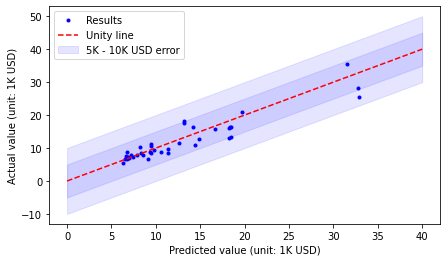

In [463]:
#From the plots above, a good model (i.e. similar MPE on training and validation sets, and low MPE) is:
# - max_depth: 3
# - n_estimators: 200
# - eta: 0.1
# - reg_lambda: 3
# - reg_alpha: 0.3

#Model training on the Training set and evaluation on the Test set
Best_xgb = xgb.XGBRegressor(max_depth = 3, n_estimators = 200, eta = 0.1, reg_lambda = 3, reg_alpha = 0.3)
Best_model_xgb = Best_xgb.fit(X_train_t,y_train_t)        #Training on the Training set
Predictions_xgb = Best_model_xgb.predict(X_test_t)        #Evaluation on the validation set
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_test_t)**2)/len(y_test_t))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_test_t))/len(y_test_t)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_test_t)/(10**y_test_t))/len(y_test_t)

print("XGBoost model")
print("----------------------")
print("RMSE: {:.2f} USD".format(RMSE_xgb))
print("MAE: {:.2f} USD".format(MAE_xgb))
print("MPE: {:.2f}%".format(MPE_xgb))

#Plot the linear values
plt.figure(figsize=(7,4))
plt.plot(10**Predictions_xgb/1000, 10**y_test_t/1000,'.b');
plt.xlabel("Predicted value (unit: 1K USD)")
plt.ylabel("Actual value (unit: 1K USD)")
plt.plot([0,40],[0,40],'--r')
plt.fill_between([0,40], [5,45], [-5,35], color="blue",alpha=0.1)
plt.fill_between([0,40], [10,50], [-10,30], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

XGBoost model
----------------------
RMSE: 1422.09 USD
MAE: 927.20 USD
MPE: 6.69%


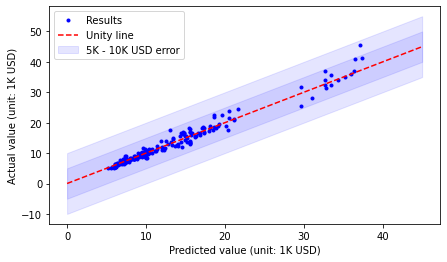

In [464]:
#Finalization of the XGBoost regression model on the whole "X_train" dataset and compute RMSE, MAE, and MPE.

Best_xgb = xgb.XGBRegressor(max_depth = 3, n_estimators = 200, eta = 0.1, reg_lambda = 3, reg_alpha = 0.3)
Best_model_xgb_final = Best_xgb.fit(X_train,y_train)
Predictions_xgb = Best_model_xgb_final.predict(X_train)
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_train)**2)/len(y_train))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_train))/len(y_train)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_train)/(10**y_train))/len(y_train)

print("XGBoost model")
print("----------------------")
print("RMSE: {:.2f} USD".format(RMSE_xgb))
print("MAE: {:.2f} USD".format(MAE_xgb))
print("MPE: {:.2f}%".format(MPE_xgb))

#Plot the linear values
plt.figure(figsize=(7,4))
plt.plot(10**Predictions_xgb/1000, 10**y_train/1000,'.b');
plt.xlabel("Predicted value (unit: 1K USD)")
plt.ylabel("Actual value (unit: 1K USD)")
plt.plot([0,45],[0,45],'--r')
plt.fill_between([0,45], [5,50], [-5,40], color="blue",alpha=0.1)
plt.fill_between([0,45], [10,55], [-10,35], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

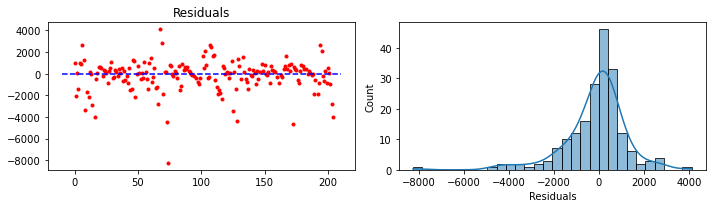

In [465]:
#Little dispersion around the unity line

#Plot the residuals
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.plot(10**Predictions_xgb-10**y_train,'.r'); plt.title("Residuals"); plt.plot([-10,210],[0,0], '--b')
plt.subplot(1,2,2); sn.histplot(x = 10**Predictions_xgb-10**y_train, bins=30, kde=True); plt.xlabel("Residuals")
plt.tight_layout()

.

.

## **8. Test on unseen data**

In [461]:
#Data preparation: transformation of the dataset with the function "Data_transformation"
X_test, y_test = Data_transformation(X_test,y_test)

RMSE: 1628.23 USD
MAE: 1239.20 USD
MPE: 8.67 %


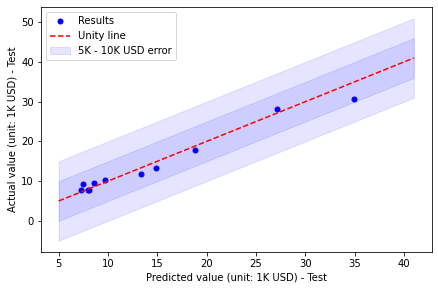

In [466]:
#XGBoost best model application
Predictions_test = Best_model_xgb_final.predict(X_test)
RMSE_linear_test = np.sqrt(sum((10**Predictions_test - 10**y_test)**2)/len(y_test))
MAE_linear_test = sum(abs(10**Predictions_test - 10**y_test))/len(y_test)
MPE_linear_test = 100*sum(abs(10**Predictions_test - 10**y_test)/(10**y_test))/len(y_test)
print("RMSE: {:.2f} USD".format(RMSE_linear_test))
print("MAE: {:.2f} USD".format(MAE_linear_test))
print("MPE: {:.2f} %".format(MPE_linear_test))

#Plot
plt.figure(figsize=(7,4.5))
plt.plot(10**Predictions_test/1000, 10**y_test/1000,'.b', markersize=10)
plt.xlabel("Predicted value (unit: 1K USD) - Test")
plt.ylabel("Actual value (unit: 1K USD) - Test")
plt.plot([5,41],[5,41],'--r')
plt.fill_between([5,41], [10,46], [0,36], color="blue",alpha=0.1)
plt.fill_between([5,41], [15,51], [-5,31], color="blue",alpha=0.1)
plt.legend(["Results","Unity line","5K - 10K USD error"],loc="upper left")